# Q3: Effect of Activation Functions on CNN Performance  
## Experiment: Sigmoid Activation

This notebook investigates how the **Sigmoid activation function** affects the
performance of a Convolutional Neural Network (CNN) on the Fashion-MNIST dataset.

The goal of this experiment is to understand whether Sigmoid is suitable for
deep convolutional architectures and to compare its behaviour with ReLU and
LeakyReLU models trained under identical conditions.

To ensure a **fair and controlled comparison**, all experimental settings
(dataset, architecture, optimiser, learning rate, batch size, and number of
epochs) are kept constant. The **only variable** changed is the activation
function.

## Experimental Setup

- **Dataset:** Fashion-MNIST (10 classes)
- **Input:** 28 × 28 grayscale images
- **Train / Validation split:** 80% / 20%

### CNN Architecture
- Conv2D: 1 → 8 filters, kernel size 3
- MaxPooling: 2 × 2
- Conv2D: 8 → 16 filters, kernel size 3
- MaxPooling: 2 × 2
- Fully connected layer: 128 units
- Output layer: 10 units

### Training Configuration
- **Activation function:** Sigmoid
- **Loss function:** CrossEntropyLoss
- **Optimiser:** Adam
- **Learning rate:** 0.01
- **Epochs:** 20

All hyperparameters and architectural choices are consistent across activation
function experiments to isolate the effect of the activation function itself.


## Imports and Setup

We import PyTorch, supporting libraries, and helper functions defined in
`functions.py`. These helper functions are shared across Q1, Q2, and Q3 to
ensure consistency and reproducibility.


In [65]:
import sys
sys.path.append("..")

from functions import get_data, data_split_train_val

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

## Dataset: Fashion-MNIST

Fashion-MNIST consists of 28×28 grayscale images across 10 clothing categories.
It is a commonly used benchmark dataset for image classification and is
well-suited for analysing CNN behaviour.


In [66]:
# Load Fashion-MNIST (normalised to [0,1])
X, y = get_data("../data/fashion-mnist_test.csv")

# Train/validation split
X_train, X_val, y_train, y_val = data_split_train_val(X, y)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (8000, 784)
Validation shape: (2000, 784)


## Data Preparation

The data is converted into PyTorch tensors and loaded using `DataLoader`.
Mini-batch training improves optimisation stability and reflects standard
deep learning practice.


In [67]:
# convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()

In [68]:
print("Before reshape:")
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_val_tensor shape:", X_val_tensor.shape)

Before reshape:
X_train_tensor shape: torch.Size([8000, 784])
X_val_tensor shape: torch.Size([2000, 784])


In [69]:
num_train = X_train_tensor.shape[0]
num_val = X_val_tensor.shape[0]

print(num_train, num_val)

8000 2000


In [70]:
X_train_tensor = X_train_tensor.reshape(num_train, 1, 28, 28)
X_val_tensor = X_val_tensor.reshape(num_val, 1, 28, 28)
print("X_train_tensor reshape:", X_train_tensor.shape)
print("X_val_tensor reshape:", X_val_tensor.shape)

X_train_tensor reshape: torch.Size([8000, 1, 28, 28])
X_val_tensor reshape: torch.Size([2000, 1, 28, 28])


In [71]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## CNN Architecture with Sigmoid Activation

This CNN architecture matches the models used in the ReLU and LeakyReLU
experiments. Sigmoid activation is applied after each convolutional layer
and the first fully connected layer.

The output layer does not apply an activation function, as
`CrossEntropyLoss` expects raw logits.


In [72]:
class CNN_Sigmoid(nn.Module):
    def __init__(self):
        super().__init__()

        self.act = nn.Sigmoid()

        self.conv1 = nn.Conv2d(1, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)

        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.act(self.fc1(x))
        return self.fc2(x)

## Training Configuration

The model is trained using the Adam optimiser and CrossEntropy loss.
All hyperparameters are identical to those used in other activation
function experiments.


In [73]:
data = CNN_Sigmoid()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(data.parameters(), lr=0.01)

## Training Loop

Both training and validation loss and accuracy are recorded at each epoch
to analyse learning behaviour.


In [74]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [75]:
epochs = 20

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass (training)
    outputs = data(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Training accuracy
    train_preds = torch.argmax(outputs, 1)
    train_acc = (train_preds == y_train_tensor).float().mean().item()
    
    # Validation loss and accuracy
    with torch.no_grad():
        val_outputs = data(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, 1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    # Store history
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(
        f"Epoch {epoch+1}/{epochs}, "
        f"Train Loss: {loss.item():.4f}, "
        f"Val Loss: {val_loss.item():.4f}, "
        f"Val Acc: {val_acc:.4f}"
    )

Epoch 1/20, Train Loss: 2.3495, Val Loss: 2.6646, Val Acc: 0.0960
Epoch 2/20, Train Loss: 2.6767, Val Loss: 2.4441, Val Acc: 0.0960
Epoch 3/20, Train Loss: 2.4479, Val Loss: 2.3704, Val Acc: 0.0965
Epoch 4/20, Train Loss: 2.3661, Val Loss: 2.3566, Val Acc: 0.0965
Epoch 5/20, Train Loss: 2.3512, Val Loss: 2.3392, Val Acc: 0.1280
Epoch 6/20, Train Loss: 2.3356, Val Loss: 2.3352, Val Acc: 0.0980
Epoch 7/20, Train Loss: 2.3339, Val Loss: 2.3347, Val Acc: 0.0980
Epoch 8/20, Train Loss: 2.3355, Val Loss: 2.3304, Val Acc: 0.1185
Epoch 9/20, Train Loss: 2.3327, Val Loss: 2.3220, Val Acc: 0.1020
Epoch 10/20, Train Loss: 2.3252, Val Loss: 2.3123, Val Acc: 0.1020
Epoch 11/20, Train Loss: 2.3157, Val Loss: 2.3039, Val Acc: 0.1020
Epoch 12/20, Train Loss: 2.3071, Val Loss: 2.2983, Val Acc: 0.1020
Epoch 13/20, Train Loss: 2.3008, Val Loss: 2.2956, Val Acc: 0.0960
Epoch 14/20, Train Loss: 2.2973, Val Loss: 2.2947, Val Acc: 0.0960
Epoch 15/20, Train Loss: 2.2955, Val Loss: 2.2940, Val Acc: 0.0960
Epoc

In [76]:
print("Final validation accuracy:", val_accuracies[-1])

Final validation accuracy: 0.1459999978542328


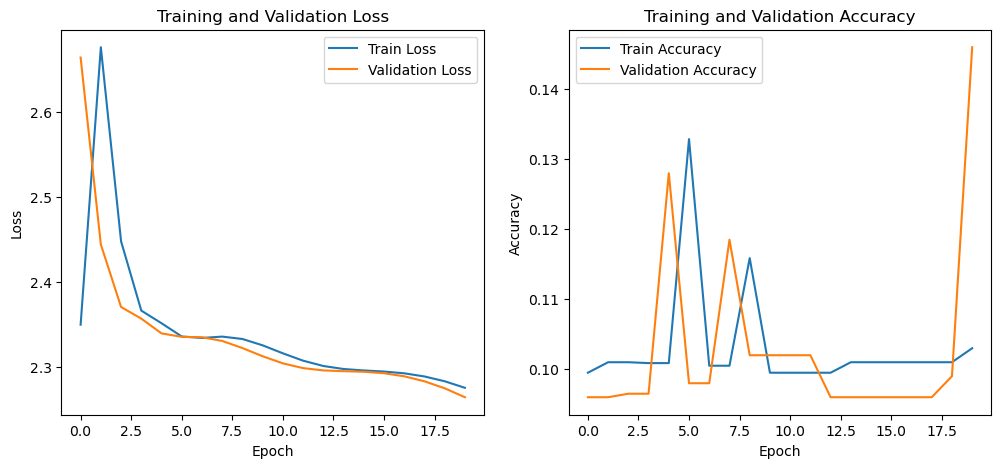

In [77]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

## Results Interpretation

The CNN using Sigmoid activation fails to learn meaningful features,
achieving a validation accuracy close to **random guessing (~10%)**.

This behaviour is expected due to the **vanishing gradient problem** associated
with Sigmoid activations. As neuron inputs grow large in magnitude, the Sigmoid
function saturates, producing near-zero gradients. This prevents effective
weight updates in deeper layers, causing training to stall.

The loss remains close to 2.30, which corresponds to the expected loss of a
random classifier across 10 classes.


## Comparison with Other Activation Functions

Compared to ReLU and LeakyReLU:
- Sigmoid converges significantly more slowly
- Gradients vanish in deeper layers
- Classification accuracy remains near chance level

These results empirically confirm why Sigmoid is no longer used in modern
deep CNN architectures.



## Conclusion

This experiment demonstrates that Sigmoid activation is unsuitable for
convolutional neural networks due to vanishing gradients and poor learning
dynamics.

When compared with ReLU and LeakyReLU, Sigmoid performs substantially worse,
highlighting the importance of activation function choice in deep learning
model design.
